In [1]:
using Gridap, Plots, Distributions, Statistics, Random, LinearAlgebra, NPZ, ProgressMeter
import Gridap: ∇

# Elliptic ODE with parametrised diffusion coefficient:

$\newcommand{R}{\mathbb{R}}$

\begin{align}
-\frac{\mathrm{d}}{\mathrm{d}x}\left(\kappa(x;p)\frac{\mathrm{d}}{\mathrm{d}x} u(x;p)\right) &= f(x), \quad x\in\Omega:=[0,1] \\
u(x) &= 0, \quad x\in\partial\Omega
\end{align}

where: $\kappa:\R\times\R^{d}\rightarrow\R$ is defined by:

$$
\log\kappa(x;p) := \sum_{k=0}^{d-1}\sqrt{2} p_{k} \cos(2\pi k x)
$$

In [2]:
function κ(x, p)
    d = length(p)
    C = cos.(2π*(0:(d-1))*x)
    log_k = √(2) * (p ⋅ C)
    return exp(log_k)
end

κ (generic function with 1 method)

In [3]:
function dκdp(x,p,j)
    return √(2)*κ(x,p)*cos(2π*j*x)
end

dκdp (generic function with 1 method)

In [4]:
function dudp(p, κ ,dκdp, x0, f, n=50, order=1)
    # set up mesh and spaces
    domain = (0,1)
    partition = (n)
    model = CartesianDiscreteModel(domain, partition)

    reffe = ReferenceFE(lagrangian,Float64,order)
    V0 = TestFESpace(model,reffe,conformity=:H1,dirichlet_tags="boundary")
    U = TrialFESpace(V0,x->0)

    degree = order + 1

    # solve for FEM solution uh of original problem (forward pass)
    Ω = Triangulation(model)
    dΩ = Measure(Ω,degree)

    kappa(x::VectorValue) = κ(x[1],p)
    a(u,v) = ∫( kappa * ∇(v)⊙∇(u) )*dΩ
    b(v) = ∫( v*f )*dΩ

    op = AffineFEOperator(a,b,U,V0)
    uh = solve(op)

    # solve for adjoint variable λ (back pass)
    δ = DiracDelta(model, Point(x0))
    b_λ(v) = -1*δ(v)
    
    op_λ = AffineFEOperator(a,b_λ,U,V0)
    λ = solve(op_λ)

    # compute derivative for each parameter and return and return
    grads = []
    d = length(p)
    for j ∈ 0:(d-1)
        dkappa(x::VectorValue) = dκdp(x[1],p,j)
        sens = sum( ∫( dkappa * ∇(λ)⋅∇(uh) )*dΩ )
        push!(grads, sens)
    end
    
    return grads
end

dudp (generic function with 3 methods)

In [5]:
f(x) = 1.0
p0 = [1.0, 2.0, 3.0]
x0 = 0.5
grads = dudp(p0, κ, dκdp, x0, f)

3-element Vector{Any}:
 -0.6676931753919948
  0.0878873483078698
  0.5599887374273123

In [6]:
# check that this agrees with the case kappa(x,p) = p constant
dudp([0.0], κ, dκdp, x0, f)/√2

1-element Vector{Float64}:
 -0.12499999999999814

In [7]:
function getAS(x0, ps, κ, dκdp, f)
    # compute gradients at each p in ps
    Grads = map(p -> dudp(p, κ, dκdp, x0, f), eachcol(ps))

    # take outer product of each grad with itself
    C_x = map(grad -> grad * grad', Grads)

    # compute mean of outer products
    C_hat = Statistics.mean(C_x)

    # eigen decomposition of C_hat
    spectrum = eigen(C_hat)
    λ = spectrum.values

    # compute proportion of spectrum explained by max eigenvector
    λ_max = max(λ...)
    prop = λ_max / sum(abs,λ)

    # get AS as leading eigenvector
    W = spectrum.vectors[:, argmax(λ)]
    @assert W' * W ≈ 1.0

    return W, λ, prop
end

getAS (generic function with 1 method)

In [8]:
Random.seed!(42)
d = 10
M = 1000
ps = rand(Uniform(-1,1), (d,M))

10×1000 Matrix{Float64}:
 -0.652851    0.0895162   0.269961    …   0.0659664  -0.455764   -0.0507548
 -0.356677   -0.132172    0.674671        0.149338    0.511436   -0.75345
 -0.482829   -0.577543    0.31992         0.253626   -0.519929    0.431709
 -0.667123   -0.633142    0.624037       -0.67943    -0.674384   -0.971075
  0.05403    -0.304983    0.791676       -0.0333991   0.0985629   0.897189
 -0.0339557   0.245294    0.160423    …  -0.595507   -0.381492    0.390764
 -0.218673   -0.94603     0.00888714      0.35914    -0.682881    0.227709
  0.605525    0.957277   -0.854679       -0.929109    0.223993    0.128417
  0.961515    0.978623    0.646139        0.255906    0.715401   -0.283017
 -0.811137   -0.889404   -0.299169       -0.0290864  -0.762057   -0.792926

In [17]:
xs = 0.01:0.025:0.99

0.01:0.025:0.985

In [18]:
AS_results = @showprogress map(x -> getAS(x, ps, κ, dκdp, f), xs);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:52


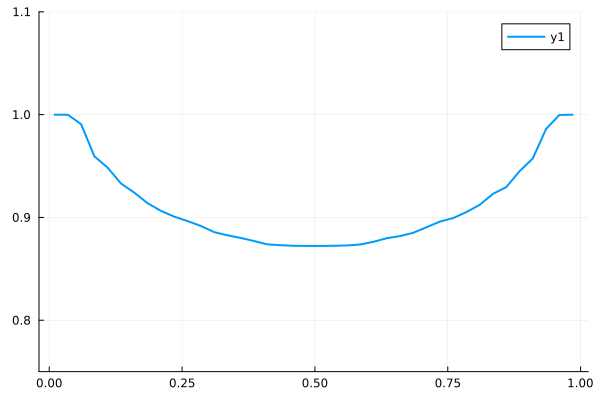

In [19]:
plot(xs,map(tup -> tup[3], AS_results),ylim=(0.75,1.1),lw=2)

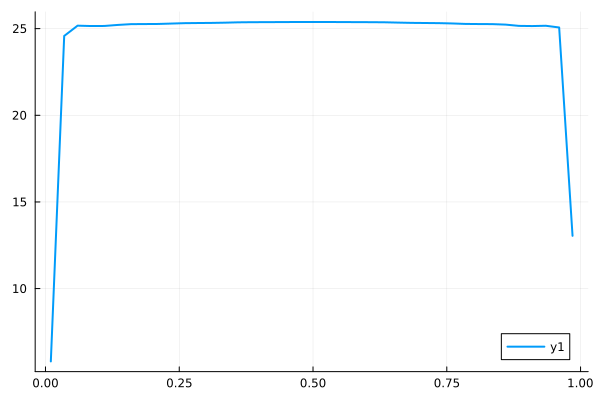

In [20]:
plot(xs,map(tup -> max(tup[2]...), AS_results),lw=2)

In [21]:
Ws = map(tup -> tup[1], AS_results)

40-element Vector{Vector{Float64}}:
 [-0.3486848419046284, -0.34743941879663204, -0.34371504411222364, -0.3375472852637481, -0.3289950340605478, -0.3181399298824837, -0.3050855600628283, -0.28995644532735043, -0.2728968202452673, -0.2540692206592053]
 [-0.3560612469265169, -0.35445547963553475, -0.34966875448308027, -0.3417917536354749, -0.33097216833267434, -0.3174096946405285, -0.30134934781949674, -0.2830733966815221, -0.2628922794148114, -0.24113490477308241]
 [-0.3619039760057298, -0.3599633738937435, -0.3542013514239353, -0.3447933646364731, -0.33201920692644976, -0.31624525382170665, -0.2979018672129925, -0.2774579364835558, -0.2553947290374706, -0.2321811986331957]
 [-0.3640698203409416, -0.36190613533373756, -0.35552528271625145, -0.34524218632096254, -0.33153267887698806, -0.31497049122901544, -0.29615752938463535, -0.27566055011678414, -0.253965007856355, -0.2314522573508137]
 [-0.3655456614067846, -0.3630835253950849, -0.35592971660913264, -0.34471458183735676, -0.330289612

In [22]:
Ws_mat = reduce(hcat, Ws)

10×40 Matrix{Float64}:
 -0.348685  -0.356061  -0.361904  …  -0.362485  -0.358467  -0.348685
 -0.347439  -0.354455  -0.359963     -0.360488  -0.356743  -0.347439
 -0.343715  -0.349669  -0.354201     -0.354568  -0.351604  -0.343715
 -0.337547  -0.341792  -0.344793     -0.344935  -0.343162  -0.337547
 -0.328995  -0.330972  -0.332019     -0.331914  -0.331592  -0.328995
 -0.31814   -0.31741   -0.316245  …  -0.315924  -0.317134  -0.31814
 -0.305086  -0.301349  -0.297902     -0.29744   -0.300079  -0.305086
 -0.289956  -0.283073  -0.277458     -0.27696   -0.280762  -0.289956
 -0.272897  -0.262892  -0.255395     -0.254972  -0.259547  -0.272897
 -0.254069  -0.241135  -0.232181     -0.231929  -0.236819  -0.254069

In [23]:
for i in 1:10
    @assert Ws_mat[:,i] == Ws[i]
end

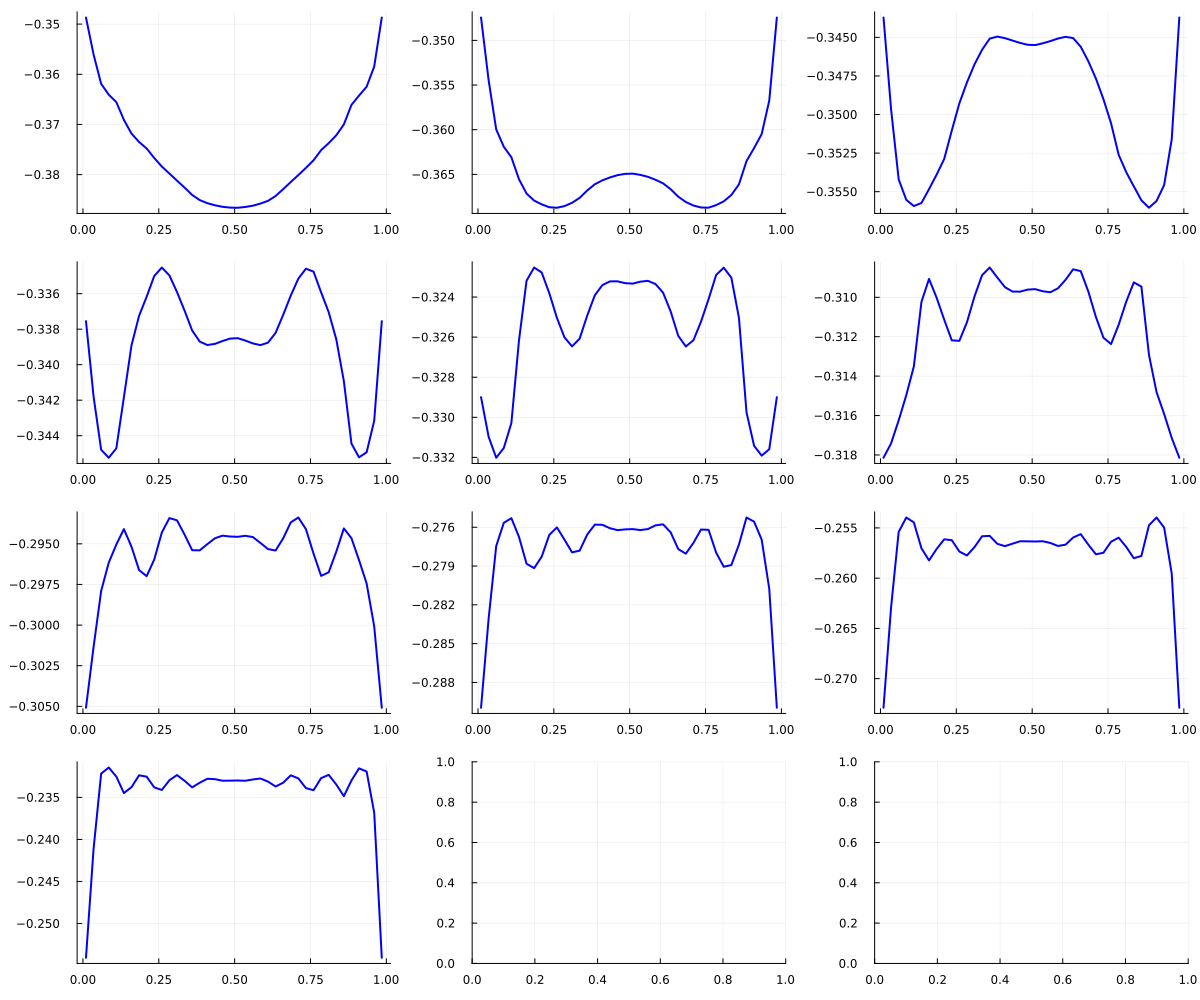

In [24]:
plot(xs, [Ws_mat[i,:] for i ∈ 1:d], 
    legend=false,
    layout=(4,3), 
    linewidth=2, 
    lc=:blue,
    size=(1200,1000),
)

In [25]:
npzwrite("xs.npz", xs)
npzwrite("Ws.npz", Ws_mat)